<a href="https://colab.research.google.com/github/aimalz/TheLastMetric/blob/master/MAFVariationalMutualInformationPzFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `TheLastMetric`: An Information Metric for Observing Strategy Optimization for Photo-z

In [2]:
!pip install --quiet pzflow corner
!git clone https://github.com/aimalz/TheLastMetric.git
%cd TheLastMetric

     |████████████████████████████████| 7.8MB 8.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Cloning into 'TheLastMetric'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 94 (delta 38), reused 41 (delta 10), pack-reused 0
Unpacking objects: 100% (94/94), done.
/content/TheLastMetric


## Loading the data

Assuming a fiducial underlying galaxy catalog, we use `OpSim` to generate observed galaxy catalogs under different observing strategies.

In [3]:
!wget https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
!tar -xzf for_malz_and_lanusse.tar.gz
!mv for_malz_and_lanusse dataset

--2021-04-07 19:17:23--  https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35901537 (34M) [application/gzip]
Saving to: ‘for_malz_and_lanusse.tar.gz’

for_malz_and_lanuss 100%[===================>]  34.24M   107MB/s    in 0.3s    

2021-04-07 19:17:23 (107 MB/s) - ‘for_malz_and_lanusse.tar.gz’ saved [35901537/35901537]



In [4]:
# more dataset/readme.txt

In [37]:
all_readme = open('dataset/readme.txt').read().split('\n')

in_metadata = []
for i, line in enumerate(all_readme[0:6]):
  descr = all_readme[i+1].split()
  in_metadata.append(descr)
print(in_metadata)

[['1_4_y10', 'baseline_v1_5_10yrs', '25.86', '27.02', '26.99', '26.42', '25.70', '24.94'], ['4_38_y10', 'footprint_stuck_rollingv1_5_10yrs', '25.56', '26.68', '26.62', '26.06', '25.33', '24.61'], ['10_92_y10', 'ddf_heavy_nexp2_v1_6_10yrs', '25.57', '26.82', '26.84', '26.26', '25.57', '24.82'], ['4_34_y10', 'footprint_newAv1_5_10yrs', '25.75', '26.87', '26.85', '26.29', '25.55', '24.78'], ['7_61_y10', 'third_obs_pt60v1_5_10yrs', '25.87', '27.03', '26.99', '26.43', '25.70', '24.93'], ['9_86_y10', 'barebones_v1_6_10yrs', '26.00', '27.13', '27.07', '26.57', '25.78', '25.05']]


In [73]:
from collections import namedtuple

metadatum = namedtuple('metadatum', ['runid', 'OpSimName', 'u', 'g', 'r', 'i', 'z', 'y']) 

metadata = {}
for row in in_metadata:
  metadata[row[0]] = metadatum(*row)

In [15]:
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=('ID', 'z_true', 
        'u', 'err_u', 'g', 'err_g', 'r', 'err_r', 'i', 'err_i', 'z', 'err_z', 'y', 'err_y', 
        'u-g', 'err_u-g', 'g-r', 'err_g-r', 'r-i', 'err_r-i', 'i-z', 'err_i-z', 'z-y', 'err_z-y')

In [60]:
# list of available catalogs
available_os = list(metadata.keys())#["run_1_4_y10", "run_4_38_y10", "run_10_92_y10", "run_4_34_y10", "run_7_61_y10", "run_9_86_y10"]
names = [metadata[runid].OpSimName for runid in available_os
    # "baseline_v1_5_10yrs",
    # "footprint_stuck_rollingv1_5_10yrs",
    # "ddf_heavy_nexp2_v1_6_10yrs",
    # "footprint_newAv1_5_10yrs",
    # "third_obs_pt60v1_5_10yrs",
    # "barebones_v1_6_10yrs",
]
os_names = dict(zip(available_os, names))
colors = ["k", "#2ca02c", "tomato", "cornflowerblue", "plum", "gold"]
os_colors = dict(zip(available_os, colors))

In [66]:
from astropy.table import Table

phot_cats, z_cats = {}, {}
for an_os in available_os:
  one_os = 'run_'+an_os
  test_cat = Table.read('dataset/'+one_os+'/test.cat', format='ascii')


  z_cat = Table.read('dataset/'+one_os+'/zphot.cat', 
                       format='ascii', 
                       names=names_z)

  phot_cat = Table.read('dataset/'+one_os+'/test.cat', 
                       format='ascii', 
                       names=names_phot)
  phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())
  phot_cats[an_os] = phot_cat
  z_cats[an_os] = z_cat

## Data exploration

In [18]:
import corner

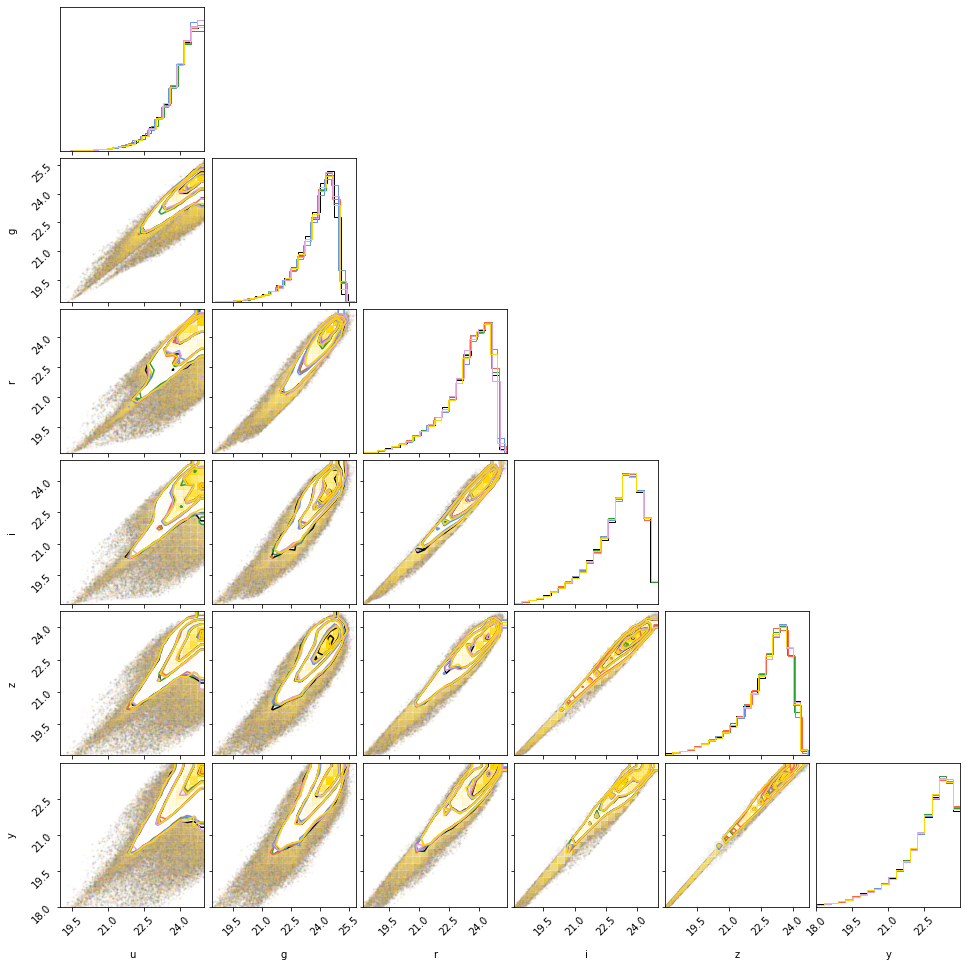

In [82]:
labels = ['u', 'g', 'r', 'i', 'z', 'y']
def prep_for_corner(one_os):
  return np.array([phot_cats[one_os][label] for label in labels]).T#[phot_cats[one_os]['u'], phot_cats[one_os]['g'], phot_cats[one_os]['r'], phot_cats[one_os]['i'], phot_cats[one_os]['z'], phot_cats[one_os]['y']]).T

for i, which_os in enumerate(available_os):
  if i == 0:
      fig = corner.corner(prep_for_corner(available_os[i]), labels=labels, alpha=0.5)
  else:
    corner.corner(prep_for_corner(which_os), fig=fig, color=os_colors[which_os], alpha=0.5)
  # corner.overplot_points(fig, [float(metadata[which_os][i+2]) for i in range(6)], color=os_colors[which_os], alpha=0.5)
  # not sure why the overplotting of limits (as lines or points) fails given corner's documentation. . .

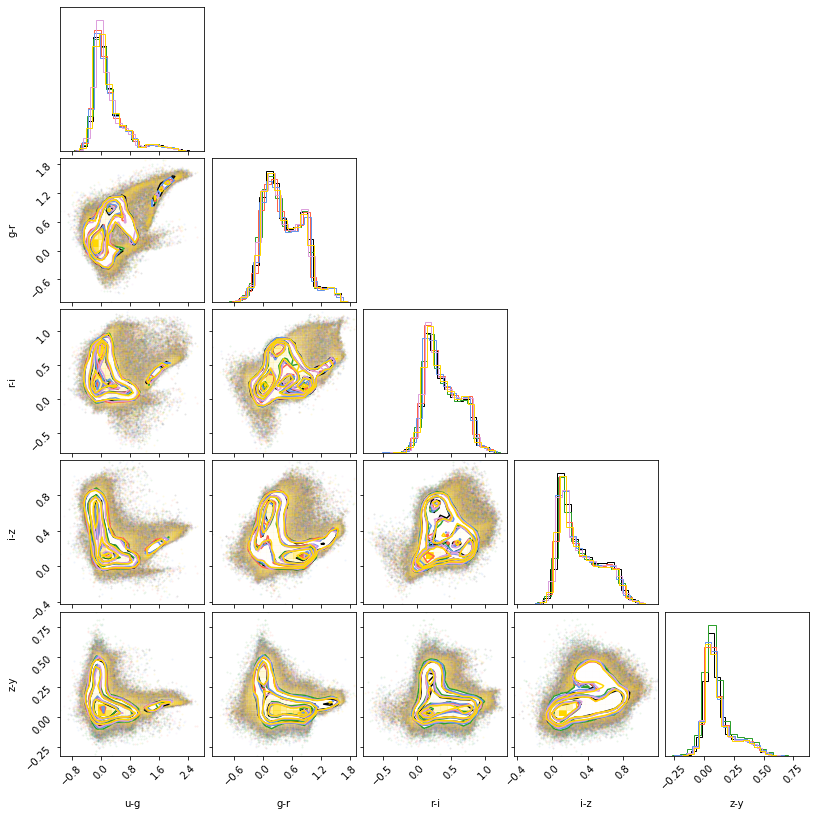

In [84]:
labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']
def prep_for_corner(one_os):
  return np.array([phot_cats[one_os]['u-g'], phot_cats[one_os]['g-r'], phot_cats[one_os]['r-i'], phot_cats[one_os]['i-z'], phot_cats[one_os]['z-y']]).T
# fig = corner.corner(prep_for_corner('run_1_4_y10'), labels=labels)
# for which_os in available_os[1:]:
#   corner.corner(prep_for_corner(which_os), fig=fig, color=os_colors[which_os])
for i, which_os in enumerate(available_os):
  if i == 0:
      fig = corner.corner(prep_for_corner(available_os[i]), labels=labels, alpha=0.5)
  else:
    corner.corner(prep_for_corner(which_os), fig=fig, color=os_colors[which_os], alpha=0.5)
# corner.corner(prep_for_corner('var_expt_v1.4_10yrs'), fig=fig, color='r')
# corner.corner(prep_for_corner('weather_1.2_v1.4_10yrs'), fig=fig, color='b')

# note to self: try some of these tricks https://github.com/tommasotreu/AARV/blob/master/attic/spare-or-old-figures/DdtDa.ipynb
# TODO: investigate those hard limits in color space
# TODO: confirm expected behavior in magnitude, not color space as well

Populating the interactive namespace from numpy and matplotlib


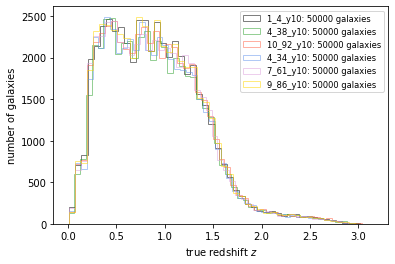

In [85]:
%pylab inline
for which_os in available_os:
  hist(z_cats[which_os]['z_true'], bins=50, alpha=0.5, histtype='step',
       color=os_colors[which_os], label=which_os+': '+str(len(phot_cats[which_os]))+' galaxies')
xlabel(r'true redshift $z$')
ylabel('number of galaxies')
legend(loc='upper right', fontsize='small')
# semilogy()
# TODO: need to deal with observed samples having same number of galaxies when, physically, they don't
# TODO: show they're the same in entropy H(Z)

In [87]:
# def calc_entropy(zgrid, p_of_z):


In [88]:
# TODO want to plot the CMNN photo-z summary stats here
# hope to establish expectations: (nexp, barebones) are pretty good, (twilight, filterdist, stuck) seem pretty bad

## Approximating the Mutual Information Lower Bound

We use a normalizing flow to approximate the distribution of redshift and photometry.

In [89]:
# Here we just need to load the PZFlow code
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import corner
from pzflow import Flow
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling

In [91]:
flows = {}
for os in available_os:
  flows[os] = Flow(file=f"trained_flows/flow_for_run_{os}.pkl")
# TODO: need to experiment with different fit parameters because this might be too smooth, also does it account for photometric errors?

In [92]:
# TODO: compare this to colors/redshifts of trained flow

In [94]:
# load the catalogs
catalogs = dict()
for os in available_os:
    z_cat = pd.read_csv(f"dataset/run_{os}/zphot.cat", names=names_z, delim_whitespace=True, skiprows=1)
    phot_cat = pd.read_csv(f"dataset/run_{os}/test.cat", names=names_phot, delim_whitespace=True)
    cat = z_cat.merge(phot_cat)
    catalogs[os] = cat.dropna()

In [95]:
# this just makes the posteriors for plotting, not sure why it uses so much memory. . .
tx = np.linspace(0,3.5,100)
all_logp = {}
for which_os in available_os:
  flow = flows[which_os]
  cat = catalogs[which_os]
  logp = flow.posterior(flow.info["condition_scaler"](cat), column="z_true", grid=tx)
  all_logp[which_os] = logp

In [96]:
# tx = np.linspace(0,3.5,100)
# logp = dist.log_prob(tx)

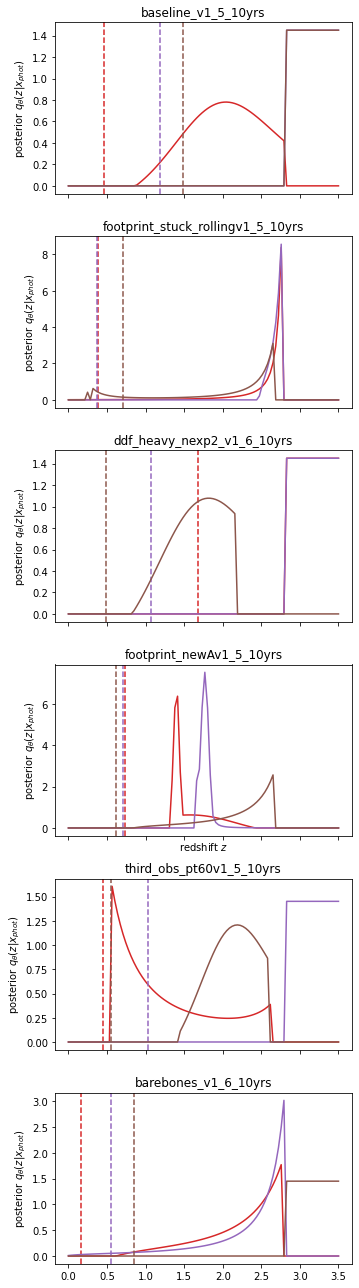

In [97]:
fig, ax = subplots(len(available_os), 1, figsize=(5, 3*len(available_os)), sharex=True)
for i, which_os in enumerate(available_os):
  ax[i].set_ylabel(r'posterior $q_{\theta}(z | x_{phot})$')
  ax[i].set_title(os_names[which_os])
  logp = all_logp[which_os]
  batch = catalogs[which_os]
  ax[i].plot(tx, (logp[0]), color='#d62728', label='photo-z posterior for galaxy 0')
  ax[i].axvline(batch['z_true'][0], linestyle='--', color='#d62728', label='true redshift of galaxy 0')
  ax[i].plot(tx, (logp[100]), color='#9467bd',  label='photo-z posterior for galaxy 100')
  ax[i].axvline(batch['z_true'][100], linestyle='--', color='#9467bd', label='true redshift of galaxy 100')
  ax[i].plot(tx, (logp[1000]), color='#8c564b', label='photo-z posterior for galaxy 1000')
  ax[i].axvline(batch['z_true'][1000], linestyle='--', color='#8c564b', label='true redshift of galaxy 1000')
  # ax[i].legend(loc='upper right')
  if i == 3:
    ax[i].set_xlabel(r'redshift $z$')
fig.tight_layout()
fig.show()
# TODO: maybe choose spread of redshifts or from particular places in color space?

This plot should show the redshift posterior distribution for given photometry $q_\theta(z | x_{phot})$. 

We are going to use that to compute our lower bound on the mutual information

$$I(z; x_{phot})  \geq \mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]  + H(z)$$ 

The second term in this bound only depends on the true redshift distribution, which stays constant between observing strategies. Only the first term depends on the observed photometry, so it is the only one we have to compare between `OpSim` runs.

In [98]:
all_milb = {}
for which_os in available_os:
  phot_cat = catalogs[which_os]

  mutual_information_lower_bound = flows[which_os].log_prob(flows[which_os].info["condition_scaler"](phot_cat))
  all_milb[which_os] = mutual_information_lower_bound
  print((os_names[which_os], np.sum(mutual_information_lower_bound)))
# TODO: make this an actual expected value rather than just sum
# also, shouldn't it be sum of exponential of metric value, since it should never penalize a negative value?

('baseline_v1_5_10yrs', DeviceArray(-inf, dtype=float32))
('footprint_stuck_rollingv1_5_10yrs', DeviceArray(-inf, dtype=float32))
('ddf_heavy_nexp2_v1_6_10yrs', DeviceArray(-inf, dtype=float32))
('footprint_newAv1_5_10yrs', DeviceArray(-inf, dtype=float32))
('third_obs_pt60v1_5_10yrs', DeviceArray(-inf, dtype=float32))
('barebones_v1_6_10yrs', DeviceArray(-inf, dtype=float32))


(DeviceArray(-inf, dtype=float32), DeviceArray(inf, dtype=float32))
(DeviceArray(-inf, dtype=float32), DeviceArray(inf, dtype=float32))
(DeviceArray(-inf, dtype=float32), DeviceArray(inf, dtype=float32))
(DeviceArray(-inf, dtype=float32), DeviceArray(inf, dtype=float32))
(DeviceArray(-inf, dtype=float32), DeviceArray(inf, dtype=float32))
(DeviceArray(-inf, dtype=float32), DeviceArray(inf, dtype=float32))


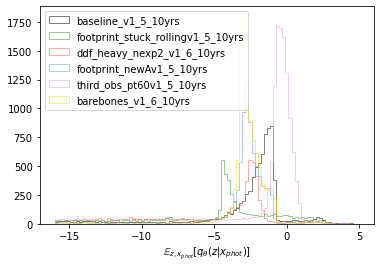

In [99]:
# surprisingly not so different from one another
for which_os in available_os:
  mutual_information_lower_bound = all_milb[which_os].flatten()
  print((np.mean(mutual_information_lower_bound), np.std(mutual_information_lower_bound)))
  hist(mutual_information_lower_bound, bins=np.linspace(-16, 5, 100), alpha=0.5, histtype='step', 
       color=os_colors[which_os], label=os_names[which_os], density=False)
  xlabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# xlim(-10., 5.)
legend(loc='upper left')
# semilogy()

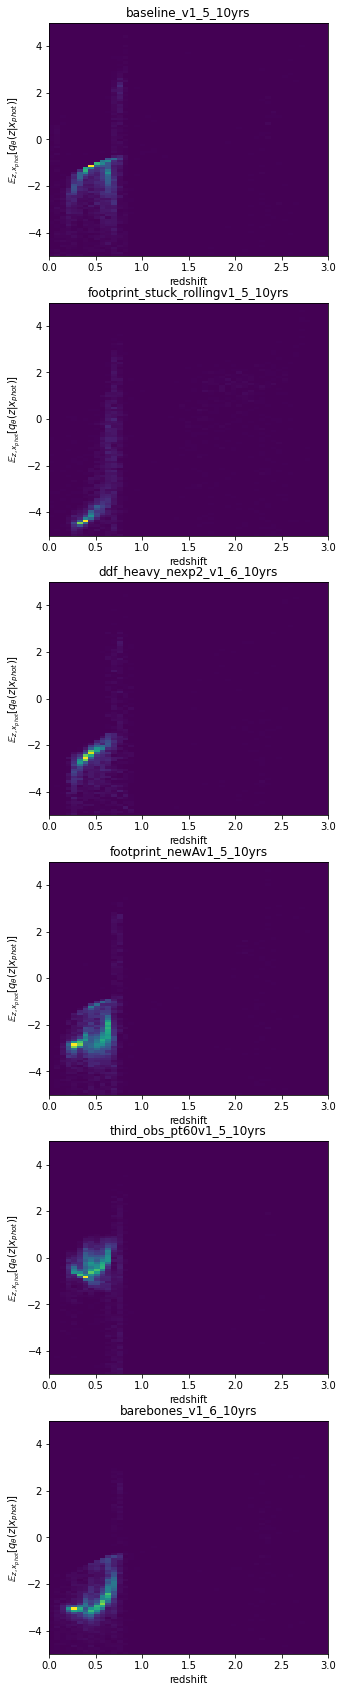

In [100]:
fig, axs = plt.subplots(len(available_os), 1, figsize=(5, 5*len(available_os)))
for i, which_os in enumerate(available_os):
  axs[i].hist2d(z_cats[which_os]['z_true'], all_milb[which_os].flatten(), bins=[np.linspace(0., 3., 50), np.linspace(-5., 5., 100)])
  axs[i].set_xlabel('redshift')
  axs[i].set_ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  axs[i].set_title(os_names[which_os])
# they're different, but not visibly so
# TODO: plot violins of metric as a function of binned redshift so they're all on one set of axes? or quantiles because outlers? or box/whisker https://matplotlib.org/stable/gallery/pyplots/boxplot_demo_pyplot.html?
# TODO: normalize within redshift bins to get these on one set of axes?
# TODO sort of want sum of metric values in redshift bins, no?

In [101]:
# import numpy as onp
# import scipy.stats as sps

In [102]:
# something isn't right about the autocalculation of moments so doing it by hand
def calc_moment(vals, k):
  n = len(vals)
  outval = np.sum(vals**k) / float(n)
  return float(outval)

In [103]:
which_moments = range(0, 5)
moment_res = {}
for which_os in available_os:
  # print((np.mean(all_milb[which_os]), np.std(all_milb[which_os])))
  moment_res[which_os] = []
  for i in which_moments:
    moment_res[which_os].append(calc_moment(all_milb[which_os], k=i))#sps.mstats.moment(all_milb[which_os], moment=which_moments[i], axis=0))
# print(moment_res)

In [104]:
# rescaled_moments = {}
# for which_os in available_os:
#   rescaled_moments[which_os] = []
# for n in which_moments:
#   vals = np.array([moment_res[which_os][n] for which_os in available_os])
#   # print(vals)
#   avg = np.mean(vals)
#   span = max(vals) - min(vals)
#   for which_os in available_os:
#     rescaled_moments[which_os].append((moment_res[which_os][n] - avg) / span)

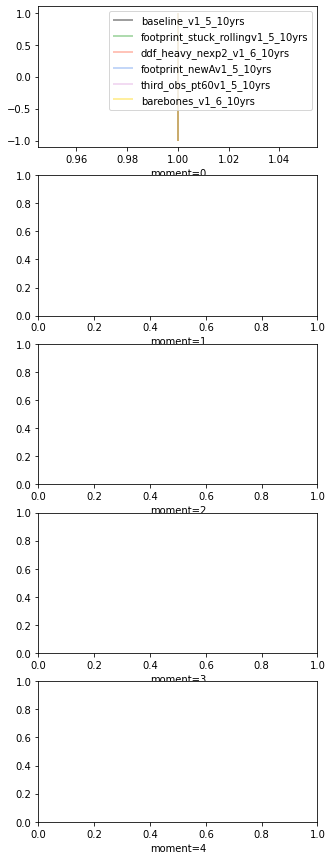

In [105]:
fig, axs = plt.subplots(len(which_moments), 1, figsize=(len(which_moments), 15))
for i in which_moments:
  for which_os in available_os:
    axs[i].vlines(moment_res[which_os][i], -1., 1., color=os_colors[which_os], alpha=0.5, label=os_names[which_os])
  axs[i].set_xlabel('moment='+str(i))
axs[0].legend()
# TODO try bootstrap samples to give this some depth
# variance is really divergent between stuck, ddf, new vs. third, barebones, baseline; suspect this is due to outliers. . . hence why bootstrap could help?

In [106]:
# # TODO: get rid of diagonal
# fig, ax = subplots(len(available_os), len(available_os), figsize=(len(available_os)-1, 20), sharey=True, sharex=True)
# hists = {}
# for j, base_os in enumerate(available_os):
#   phot_cat = phot_cats[base_os]
#   mutual_information_lower_bound = all_milb[base_os]
#   x = onp.linspace(0., 2.5, 64)
#   y = onp.linspace(-5., 1., 64)
#   h, x, y = onp.histogram2d(phot_cat['z_true'], mutual_information_lower_bound.flatten(), bins=(x, y), density=True)#64)#, extent=np.array([[0.,2.5], [-5.,1.]]))
#   hists[base_os] = h
# extrema = [0., 0.]
# for j, base_os in enumerate(available_os):
#   for i, comp_os in enumerate(available_os):
#     diff_hist = hists[base_os] - hists[comp_os]
#     comp_extrema = [onp.min(diff_hist), onp.max(diff_hist)]
#     extrema = [min(comp_extrema[0], extrema[0]), max(comp_extrema[1], extrema[1])]
#     img = ax[j][i].imshow(diff_hist.T, origin='lower', cmap=mpl.cm.viridis_r, vmin=-0.4, vmax=0.4, extent=[0.,2.5,-5.,1.], aspect='auto')
#     ax[j][i].text(0., 1.1, base_os+' - '+comp_os)
#     ax[j][i].set_ylabel(r'$\Delta\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#     fig.colorbar(img, ax=ax[j][i])
#     ax[j][i].set_xlabel(r'redshift $z$')
# fig.tight_layout()
# fig.show()
# print(extrema)

In [107]:
# next step: make corner plot of differences between distributions as 2D histograms, since contour/KDE fails

## OLD! Computing the bound for various opsim runs

In [108]:
test_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/test.cat', format='ascii')

names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
z_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/zphot.cat', 
                       format='ascii', 
                       names=names_z)

names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')
phot_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/test.cat', 
                       format='ascii', 
                       names=names_phot)
phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())

FileNotFoundError: ignored

In [ ]:
batch_size = 512
def get_batch():
  inds = onp.random.choice(len(phot_cat), size=batch_size)
  x = np.stack([phot_cat['u-g'][inds], phot_cat['g-r'][inds], phot_cat['r-i'][inds],
                phot_cat['i-z'][inds],phot_cat['z-y'][inds] ]).astype('float32').T
  y = np.array(phot_cat['z_true'][inds]).astype('float32').reshape((-1,1))
  return {'x':x, 'y':y}

In [ ]:
_, initial_params = ConditionalDensityEstimator.init_by_shape(jax.random.PRNGKey(0),
                                           [((1, 5), np.float32)])

model = flax.nn.Model(ConditionalDensityEstimator, initial_params)

optimizer = flax.optim.Adam(learning_rate=0.001).create(model)

losses = []

In [ ]:
for epoch in range(10000):
  batch = get_batch()
  optimizer, l = train_step(optimizer, batch)
  if epoch % 1000 == 0:
    print(epoch, l)
  losses.append(l)

In [ ]:
plot(np.array(losses[2000:]))

In [ ]:
batch = get_batch()
dist = optimizer.target(batch['x'])

In [ ]:
tx = np.linspace(0,3.5,100)
logp = dist.log_prob(tx)

In [ ]:
plot(tx, np.exp(logp[0]))
axvline(batch['y'][0], color='C0')
plot(tx, np.exp(logp[1]))
axvline(batch['y'][1], color='C1')

In [ ]:
x = np.stack([phot_cat['u-g'], phot_cat['g-r'], phot_cat['r-i'],
              phot_cat['i-z'],phot_cat['z-y']]).astype('float32').T
y = np.array(phot_cat['z_true']).astype('float32').reshape((-1,1))

mutual_information_lower_bound = model(x).log_prob(y)

In [ ]:
np.mean(mutual_information_lower_bound)

In [ ]:
hist2d(phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64,
       range=[[0,2.5], [-5,1]]);
xlabel('Redshift')
ylabel(r'$\mathbb{E}_{z, phot} \left[ q_\theta(z | phot ) \right]$')
title('weather_1.2_v1.4_10yrs')

In [ ]:
mutual_information_lower_bound.shape